In [2]:
import os
import sys
import gc
import numpy as np
import pandas as pd
import line_profiler

In [3]:
os.chdir('..')

In [5]:
sys.path.append('.')
sys.path.append('src')

In [6]:
from cafa_utils import *
from data_utils import *

## Optimize label generation

Currently, the label dataframe generation takes quite a while to calculate. We'll start by profiling the function with line_profiler.

In [7]:
train_protein_ids = np.load('./input/t5embeds/train_ids.npy')
test_protein_ids = np.load('./input/t5embeds/test_ids.npy')

In [8]:
n_labels = 1500

In [10]:
train_embeddings = np.load('./input/esm23b/train_embeds_esm2_t36_3B_UR50D.npy')
test_embeddings = np.load('./input/esm23b/test_embeds_esm2_t36_3B_UR50D.npy')

In [11]:
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, train_embeddings.shape[1]+1)])
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, test_embeddings.shape[1]+1)])
labels_to_consider = train_terms['term'].value_counts().index[:n_labels].tolist()    

In [15]:
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels_to_consider)]

In [13]:
%load_ext line_profiler

In [16]:
%lprun -f create_labels_df create_labels_df(train_protein_ids, train_terms_updated, n_labels, labels_to_consider)

  0%|          | 0/1500 [00:00<?, ?it/s]

Timer unit: 1e-09 s

Total time: 308.72 s
File: /media/joni/2T-2/kaggle/cafa5/src/cafa_utils.py
Function: create_labels_df at line 55

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    55                                           def create_labels_df(train_protein_ids, train_terms_updated, num_of_labels, labels_to_consider):
    56                                               # Create an empty dataframe of required size for storing the labels,
    57                                               # i.e, train_size x num_of_labels (142246 x 1500)
    58         1       2552.0   2552.0      0.0      train_size = train_protein_ids.shape[0] # len(X)
    59         1      36174.0  36174.0      0.0      train_labels = np.zeros((train_size ,num_of_labels))
    60                                           
    61                                               # Convert from numpy to pandas series for better handling
    62         1   11392505.0 11392505.0      0.0      series_train_protein_ids = pd.Series(train_protein_ids)
    63                                           
    64                                               # Loop through each label
    65      1500 1019739976.0 679826.7      0.3      for i in tqdm(range(num_of_labels), total=num_of_labels):
    66                                                   # For each label, fetch the corresponding train_terms data
    67      1500 291263595709.0 194175730.5     94.3          n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels_to_consider[i]]
    68                                                   
    69                                                   # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    70      1500  664165983.0 442777.3      0.2          label_related_proteins = n_train_terms['EntryID'].unique()
    71                                                   
    72                                                   # In the series_train_protein_ids pandas series, if a protein is related
    73                                                   # to the current label, then mark it as 1, else 0.
    74                                                   # Replace the ith column of train_Y with with that pandas series.
    75      1500 15761181966.0 10507454.6      5.1          train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    76                                           
    77                                               # Convert train_Y numpy into pandas dataframe
    78         1     295587.0 295587.0      0.0      return pd.DataFrame(data = train_labels, columns = labels_to_consider)

In [17]:
def create_labels_df_optimized(train_protein_ids, train_terms_updated, num_of_labels, labels_to_consider):
    # Create a DataFrame with EntryID as index and term as columns
    df = train_terms_updated.pivot_table(index='EntryID', columns='term', aggfunc='size', fill_value=0)
    df = df.loc[:, labels_to_consider].clip(upper=1)
    
    # Reindex the DataFrame with all possible train_protein_ids to include proteins with no labels
    df = df.reindex(train_protein_ids, fill_value=0)

    # Return the DataFrame with correct column names
    return df

In [18]:
%lprun -f create_labels_df_optimized create_labels_df_optimized(train_protein_ids, train_terms_updated, n_labels, labels_to_consider)

Timer unit: 1e-09 s

Total time: 11.6488 s
File: /tmp/ipykernel_39104/4133215989.py
Function: create_labels_df_optimized at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def create_labels_df_optimized(train_protein_ids, train_terms_updated, num_of_labels, labels_to_consider):
     2                                               # Create a DataFrame with EntryID as index and term as columns
     3         1 9467894568.0 9467894568.0     81.3      df = train_terms_updated.pivot_table(index='EntryID', columns='term', aggfunc='size', fill_value=0)
     4         1 1121593117.0 1121593117.0      9.6      df = df.loc[:, labels_to_consider].clip(upper=1)
     5                                               
     6                                               # Reindex the DataFrame with all possible train_protein_ids to include proteins with no labels
     7         1 1059269218.0 1059269218.0      9.1      df = df.reindex(train_protein_ids, fill_value=0)
     8                                           
     9                                               # Return the DataFrame with correct column names
    10         1        922.0    922.0      0.0      return df

In [19]:
labels_df_optimized = create_labels_df_optimized(train_protein_ids, train_terms_updated, n_labels, labels_to_consider)
labels_df_optimized.head()

term,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874,GO:0016887
EntryID,,,,,,,,,,,,,,,,,,,,,
P20536,0,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
O73864,1,1,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
O95231,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
A0A0B4J1F4,1,1,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
P54366,1,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
labels_df_fn = f'./output/t5_train_labels_num_lbl-{n_labels}.csv'
labels_df = pd.read_csv(labels_df_fn)
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874,GO:0016887
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
np.all(labels_df.values == labels_df_optimized.values)

True

## Target compression

In [27]:
# Take 1000 labels of each ontology but 2000 from BPO
num_of_labels = 1000
labels_bpo = train_terms[train_terms['aspect'] == 'BPO']['term'].value_counts().index[:num_of_labels * 2].tolist()
labels_cco = train_terms[train_terms['aspect'] == 'CCO']['term'].value_counts().index[:num_of_labels].tolist()
labels_mfo = train_terms[train_terms['aspect'] == 'MFO']['term'].value_counts().index[:num_of_labels].tolist()
labels_all = labels_bpo + labels_cco + labels_mfo

In [30]:
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels_all)]

In [31]:
labels_df = create_labels_df_optimized(train_protein_ids, train_terms_updated, 0, labels_all)

In [32]:
labels_df.head()

term,GO:0008150,GO:0009987,GO:0065007,GO:0050789,GO:0050794,GO:0050896,GO:0008152,GO:0032501,GO:0032502,GO:0071704,...,GO:0016886,GO:0070840,GO:0034237,GO:0032977,GO:0036122,GO:0015271,GO:0004630,GO:0050699,GO:0008970,GO:0008327
EntryID,,,,,,,,,,,,,,,,,,,,,
P20536,1,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
O73864,1,1,1,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
O95231,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A0B4J1F4,1,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
P54366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
import torch
import torch.nn as nn

class LabelEmbeddingAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(4000, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 384),
            torch.nn.Sigmoid()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(384, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 4000),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [35]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=5, shuffle=True, random_state=123)

for (train_index, test_index) in skf.split(labels_df):
    break
    
X_train = torch.tensor(labels_df.iloc[train_index].values.astype(np.float32))
X_val = torch.tensor(labels_df.iloc[test_index].values.astype(np.float32))

In [36]:
batch_size = 64
dl = FastTensorDataLoader(X_train, X_train, batch_size=batch_size, shuffle=True)
dl_val = FastTensorDataLoader(X_val, X_val, batch_size=batch_size, shuffle=False)

In [41]:
device='cuda'
criterion = nn.BCELoss().to(device)

In [48]:
model = LabelEmbeddingAE().to(device)

In [49]:
from binarymetrics import BinaryMetrics

In [50]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

epochs = 50
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
scaler = torch.cuda.amp.GradScaler()

binarymetrics = BinaryMetrics(device=device)

In [53]:
from tqdm.auto import tqdm

tkep = tqdm(range(1, epochs + 1), desc="epoch", leave=True, position=0)
for epoch in tkep:
    logs = {}
    model.train()
    
    running_loss_trn = 0
        
    tk0 = tqdm(dl, total=int(len(dl)), leave=False, position=1)
    for cpu_data in tk0:
        data = (cpu_data[0].to(device), cpu_data[1].to(device))
        optimizer.zero_grad()
        
        #with torch.cuda.amp.autocast():
        probs = model(data[0])
        loss = criterion(probs, data[1])

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss_trn += loss.item()
        
        binarymetrics.accumulate_batch(probs.detach(), data[1])
    logs['train_loss'] = running_loss_trn / len(dl)
    binarymetrics.compute(logs=logs, prefix='train_')
    
    scheduler.step()
    
    # evaluate
    model.eval()
    loss_val  = 0
    tk1 = tqdm(
        dl_val, total=int(len(dl_val)), 
        desc="validating", ascii=True, leave=False, position=1)
    
    for cpu_data in tk1:
        data = (cpu_data[0].to(device), cpu_data[1].to(device))
        with torch.no_grad(): # and torch.cuda.amp.autocast():
            probs = model(data[0])
            loss_val += criterion(probs, data[1]).item()

            binarymetrics.accumulate_batch(probs.detach(), data[1])
    
    logs['val_loss'] = loss_val / len(dl_val)
    binarymetrics.compute(logs=logs, prefix='val_')
    tkep.set_postfix(
        train_loss=logs['train_loss'], train_f1=logs['train_f1'], 
        val_loss=logs['val_loss'],val_f1=logs['val_f1'])

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

In [54]:
for val_batch in dl_val:
    break

In [55]:
val_batch[0]

tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [56]:
pred = model.encoder(val_batch[0].to(device)).detach()

(array([12527.,  2089.,  1487.,  1210.,  1014.,   755.,   770.,   793.,
         1049.,  2882.]),
 array([3.32913423e-24, 1.00000001e-01, 2.00000003e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 8.99999976e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

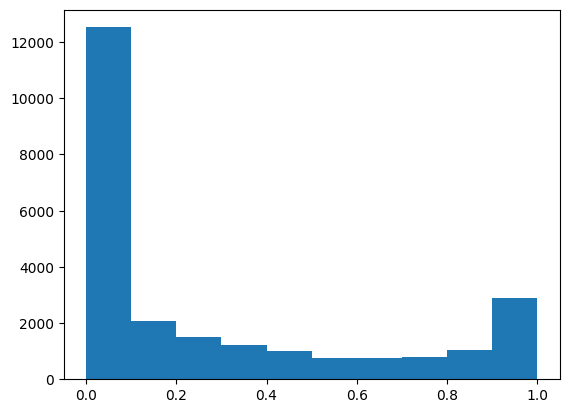

In [59]:
import matplotlib.pyplot as plt

plt.hist(pred.cpu().ravel())

In [61]:
pred_decoded = model.decoder(pred).detach()

(array([2.53324e+05, 2.92000e+02, 1.48000e+02, 9.80000e+01, 8.40000e+01,
        7.70000e+01, 8.10000e+01, 7.30000e+01, 8.00000e+01, 1.74300e+03]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

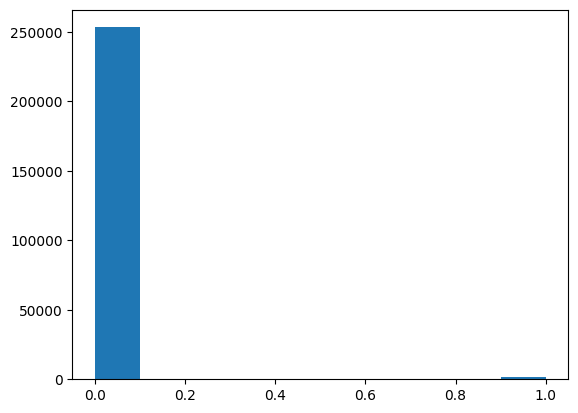

In [62]:
plt.hist(pred_decoded.cpu().ravel())

(array([253849.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   2151.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

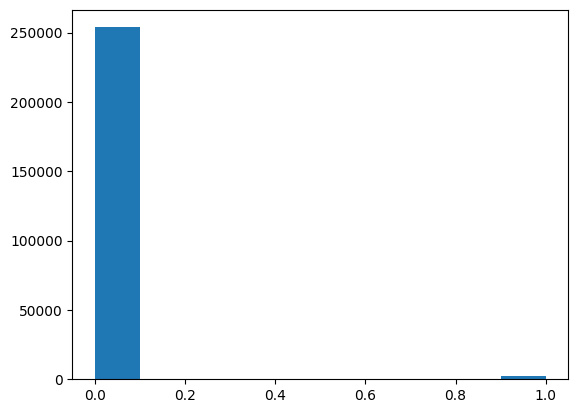

In [63]:
plt.hist(val_batch[0].ravel())

## Variational Autoencoder

In [64]:
class LabelEmbeddingVAE(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim
        
        # Encoder layers
        self.fc1 = torch.nn.Linear(4000, 2048)
        self.fc2_mu = torch.nn.Linear(2048, self.latent_dim)
        self.fc2_logvar = torch.nn.Linear(2048, self.latent_dim)

        # Decoder layers
        self.fc3 = torch.nn.Linear(self.latent_dim, 1024)
        self.fc4 = torch.nn.Linear(1024, 2048)
        self.fc5 = torch.nn.Linear(2048, 4000)
        self.activation = torch.nn.ReLU()

    def encode(self, x):
        h1 = self.activation(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        h3 = self.activation(self.fc3(z))
        h4 = self.activation(self.fc4(h3))
        decoded = torch.sigmoid(self.fc5(h4))
        return decoded

    def forward(self, x):
        # Encode the input and sample latent vector
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        # Decode the latent vector
        decoded = self.decode(z)

        return decoded, mu, logvar
    
model = LabelEmbeddingVAE(latent_dim=384).to(device)

In [65]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    reconstruction_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine the two losses
    total_loss = reconstruction_loss + kl_divergence

    return total_loss

In [66]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

epochs = 50
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
scaler = torch.cuda.amp.GradScaler()

binarymetrics = BinaryMetrics(device=device)

In [67]:
tkep = tqdm(range(1, epochs + 1), desc="epoch", leave=True, position=0)
for epoch in tkep:
    logs = {}
    model.train()
    
    running_loss_trn = 0
        
    tk0 = tqdm(dl, total=int(len(dl)), leave=False, position=1)
    for cpu_data in tk0:
        data = (cpu_data[0].to(device), cpu_data[1].to(device))
        optimizer.zero_grad()
        
        #with torch.cuda.amp.autocast():
        recon_x, mu, logvar = model(data[0])
        loss = vae_loss(recon_x, data[1], mu, logvar)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss_trn += loss.item()
        
        binarymetrics.accumulate_batch(recon_x.detach(), data[1])
    logs['train_loss'] = running_loss_trn / len(dl)
    binarymetrics.compute(logs=logs, prefix='train_')
    
    scheduler.step()
    
    # evaluate
    model.eval()
    loss_val  = 0
    tk1 = tqdm(
        dl_val, total=int(len(dl_val)), 
        desc="validating", ascii=True, leave=False, position=1)
    
    for cpu_data in tk1:
        data = (cpu_data[0].to(device), cpu_data[1].to(device))
        with torch.no_grad(): # and torch.cuda.amp.autocast():
            recon_x, mu, logvar = model(data[0])
            loss_val += vae_loss(recon_x, data[1], mu, logvar).item()

            binarymetrics.accumulate_batch(recon_x.detach(), data[1])
    
    logs['val_loss'] = loss_val / len(dl_val)
    binarymetrics.compute(logs=logs, prefix='val_')
    tkep.set_postfix(
        train_loss=logs['train_loss'], train_f1=logs['train_f1'], 
        val_loss=logs['val_loss'],val_f1=logs['val_f1'])

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1779 [00:00<?, ?it/s]

validating:   0%|          | 0/445 [00:00<?, ?it/s]

In [73]:
torch.save(model.state_dict(), './output/vae_label_encoder_v1.pth')

(array([2.800e+01, 2.420e+02, 1.430e+03, 4.512e+03, 7.655e+03, 6.599e+03,
        3.244e+03, 7.730e+02, 8.600e+01, 7.000e+00]),
 array([-3.9483552 , -3.12716722, -2.30597925, -1.48479116, -0.66360313,
         0.15758491,  0.97877294,  1.79996097,  2.62114906,  3.44233704,
         4.26352501]),
 <BarContainer object of 10 artists>)

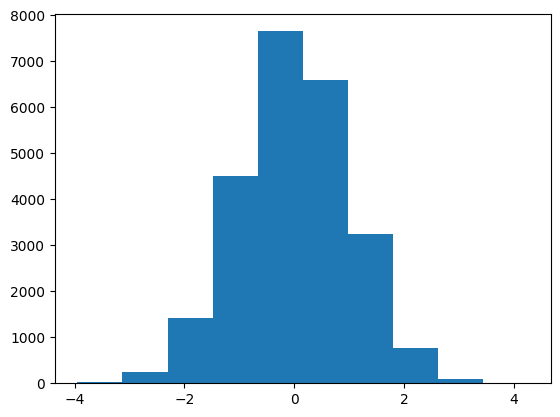

In [74]:
for val_batch in dl_val:
    break
    
mu, logvar = model.encode(val_batch[0].to(device))
z = model.reparameterize(mu, logvar)
plt.hist(z.detach().cpu().ravel())

(array([2.53204e+05, 3.95000e+02, 2.22000e+02, 1.57000e+02, 1.03000e+02,
        8.10000e+01, 6.90000e+01, 1.10000e+02, 1.51000e+02, 1.50800e+03]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

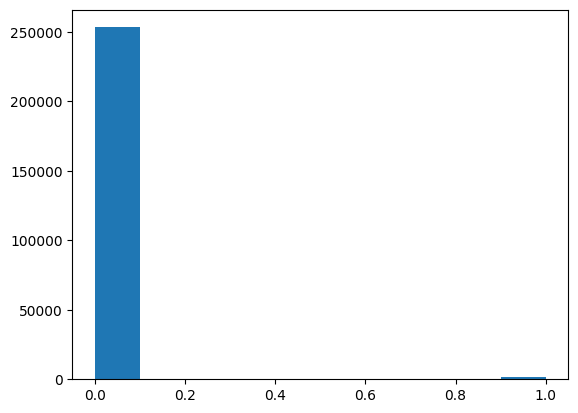

In [75]:
pred_decoded = model.decode(z)
plt.hist(pred_decoded.detach().cpu().ravel())

In [1]:
import pandas as pd

In [4]:
df_sub = pd.read_csv('../output/20230804-112845/submission.tsv', sep='\t', names=['Protein Id', 'GO Term Id', 'Prediction'])
df_sub.head()

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0008150,0.999999
1,Q9CQV8,GO:0009987,0.992625
2,Q9CQV8,GO:0065007,0.999880
3,Q9CQV8,GO:0050789,0.999690
4,Q9CQV8,GO:0050794,0.994723


In [5]:
import numpy as np
df_sub['Prediction'] = df_sub['Prediction'].round(decimals=3)
df_sub.head()

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0008150,1.000
1,Q9CQV8,GO:0009987,0.993
2,Q9CQV8,GO:0065007,1.000
3,Q9CQV8,GO:0050789,1.000
4,Q9CQV8,GO:0050794,0.995


In [ ]:
df_sub.to_csv('../output/20230804-112845/submission_downcasted.tsv', header=False, index=False, sep="\t")